# MLP-Based Stock Price Prediction

- Hugging Face Transformers의 PatchTSMixer 모델을 이용한다 : https://huggingface.co/docs/transformers/model_doc/patchtsmixer
- 다음 github의 demo를 참고한다: https://github.com/IBM/tsfm

# 0. Import Libraries

# 1. Preprocessing

## 1.0. Load Data

In [99]:
import pandas as pd
import numpy as np
import torch

class Data():
    def __init__(self):
        # 크롤링 데이터
        self.close = pd.read_csv('data/close.csv', thousands = ',', index_col = 0) # 종가
        self.close.index = pd.to_datetime(self.close.index) # 일자 datetime 타입으로 변환
        self.high = pd.read_csv('data/high.csv', thousands = ',', index_col = 0) # 고가
        self.high.index = pd.to_datetime(self.high.index)
        self.low = pd.read_csv('data/low.csv', thousands = ',', index_col = 0) # 저가
        self.low.index = pd.to_datetime(self.low.index)
        self.open = pd.read_csv('data/open.csv', thousands = ',', index_col = 0) # 시가
        self.open.index = pd.to_datetime(self.open.index)
        self.volume = pd.read_csv('data/volume.csv', thousands = ',', index_col = 0) # 거래량
        self.volume.index = pd.to_datetime(self.volume.index)
        
        self.market_equity_kospi = pd.read_csv('data/market_equity_kospi.csv', thousands = ',', index_col = 0) # 시가총액
        self.market_equity_kospi.index = pd.to_datetime(self.market_equity_kospi.index)
        
        self.top50 = pd.read_csv('data/top50.csv', thousands = ',', index_col = 0) # 시가총액 상위 50위
        
        self.stock_log_return = np.log(self.close).diff(1)

In [100]:
data = Data()

In [101]:
# log_return의 역연산
def inv_log_return(original, log_return):
    return original*np.exp(log_return)

original = 505463
log_return = np.log(pd.Series([505463, 453444])).diff(1)[1]
print("log_return:", log_return)
answer = 453444
print("error:", inv_log_return(original, log_return) - answer)

log_return: -0.10860306300789091
error: 4.0745362639427185e-10


In [43]:
inv_log_return(torch.tensor([6110, 5580, 5620]), torch.tensor([-0.090738, 0.007143, -0.014337]))

tensor([5580.0000, 5620.0010, 5540.0005])

## 1.1. Make Custom Dataset

In [44]:
data.close

,A005930,A373220,A000660,A207940,A005490,A005380,A051910,A006400,A000270,A035420,...,A138250,A144620,A152330,A192520,A192530,A900030,A900050,A950010,A950070,A950100
2000-01-04,6110,NaN,505463,NaN,142000,20700,NaN,50400,7350,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,5580,NaN,453444,NaN,149500,20800,NaN,47500,6950,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,5620,NaN,429889,NaN,144500,19700,NaN,43000,6650,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,5540,NaN,425963,NaN,145000,20300,NaN,41000,6500,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-10,5770,NaN,422037,NaN,143000,20000,NaN,41600,6800,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-25,69400,476000.0,117000,694000.0,539000,192900,509000.0,521000,82100,206500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-26,68600,475500.0,115000,680000.0,533000,190700,505000.0,522000,80900,201000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-27,68400,476500.0,114700,681000.0,535000,191100,496500.0,512000,81400,201500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-04,67500,456000.0,115400,691000.0,511000,190800,486000.0,484500,81900,191200.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
data.stock_log_return

,A005930,A373220,A000660,A207940,A005490,A005380,A051910,A006400,A000270,A035420,...,A138250,A144620,A152330,A192520,A192530,A900030,A900050,A950010,A950070,A950100
2000-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,-0.090738,NaN,-0.108603,NaN,0.051469,0.004819,NaN,-0.059261,-0.055959,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,0.007143,NaN,-0.053345,NaN,-0.034017,-0.054334,NaN,-0.099530,-0.044125,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,-0.014337,NaN,-0.009175,NaN,0.003454,0.030002,NaN,-0.047628,-0.022815,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-10,0.040678,NaN,-0.009260,NaN,-0.013889,-0.014889,NaN,0.014528,0.045120,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-25,0.008683,-0.031026,-0.002561,-0.012885,-0.054165,0.007284,-0.015595,-0.022771,0.023415,-0.007238,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-26,-0.011594,-0.001051,-0.017242,-0.020379,-0.011194,-0.011470,-0.007890,0.001918,-0.014724,-0.026996,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-27,-0.002920,0.002101,-0.002612,0.001470,0.003745,0.002095,-0.016975,-0.019343,0.006161,0.002484,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-04,-0.013245,-0.043975,0.006084,0.014578,-0.045897,-0.001571,-0.021375,-0.055207,0.006124,-0.052469,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
data.top50

,2007-01-02,2007-01-30,2007-02-28,2007-03-29,2007-04-26,2007-05-28,2007-06-26,2007-07-25,2007-08-23,2007-09-20,...,2021-12-20,2022-01-18,2022-02-18,2022-03-22,2022-04-19,2022-05-18,2022-06-17,2022-07-15,2022-08-12,2022-09-14
0,A005930,A005930,A005930,A005930,A005930,A005930,A005930,A005930,A005930,A005930,...,A005930,A005930,A005930,A005930,A005930,A005930,A005930,A005930,A005930,A005930
1,A015760,A005490,A005490,A005490,A005490,A005490,A005490,A005490,A005490,A005490,...,A000660,A000660,A373220,A373220,A373220,A373220,A373220,A373220,A373220,A373220
2,A005490,A015760,A060000,A060000,A060000,A060000,A060000,A015760,A015760,A009540,...,A207940,A035420,A000660,A000660,A000660,A000660,A000660,A000660,A000660,A000660
3,A060000,A060000,A015760,A015760,A015760,A015760,A009540,A060000,A009540,A015760,...,A035420,A207940,A035420,A207940,A207940,A207940,A207940,A207940,A207940,A207940
4,A055550,A055550,A055550,A055550,A055550,A009540,A015760,A009540,A060000,A060000,...,A035720,A051910,A207940,A035420,A035420,A035420,A051910,A005380,A051910,A051910
5,A017670,A053000,A053000,A053000,A053000,A055550,A055550,A055550,A055550,A055550,...,A051910,A006400,A051910,A035720,A035720,A006400,A035420,A035420,A035420,A005380
6,A053000,A017670,A017670,A017670,A009540,A053000,A053000,A053000,A053000,A017670,...,A006400,A005380,A035720,A005380,A006400,A005380,A006400,A006400,A006400,A006400
7,A000660,A005380,A005380,A000660,A017670,A017670,A017670,A005380,A000660,A053000,...,A005380,A035720,A005380,A006400,A005380,A035720,A005380,A051910,A005380,A035420
8,A005380,A000660,A000660,A009540,A000660,A005380,A005380,A000660,A017670,A005380,...,A000270,A000270,A006400,A051910,A051910,A051910,A035720,A000270,A035720,A000270
9,A030200,A030200,A009540,A005380,A034220,A034220,A000660,A017670,A005380,A034220,...,A323410,A105560,A000270,A000270,A000270,A000270,A000270,A035720,A000270,A035720


In [47]:
from torch.utils.data import Dataset
from tsfm_public.toolkit.dataset import ForecastDFDataset
from sklearn.preprocessing import StandardScaler

class CustomDataset(ForecastDFDataset):
    def __init__(self, start_date, last_date, data=data, context_length=120, forecast_horizon=20):
        """
        start_date:str | 처음 리밸런싱 날짜. (train/val/test) 구분할 때 이용
        last_date:str | 마지막 리밸런싱 날짜. (train/val/test) 구분할 때 이용
        data | Data() 클래스의 인스턴스
        context_length:int | 예측에 사용할 영업일수 (default: 120일)
        forecast_horizon:int | 예측할 영업일수 (default: 20일)
        """
        self.start_date = start_date
        self.last_date = last_date
        
        self.top50 = data.top50
        self.close = data.close
        self.high = data.high
        self.low = data.low
        self.open = data.open
        self.volume = data.volume
        self.stock_log_return = data.stock_log_return

        self.context_length = context_length
        self.forecast_horizon = forecast_horizon

        self.index_list = [] # 데이터가 존재하는 index 리스트
        self.count_samples()

    def __len__(self):
        return len(self.index_list)

    def __getitem__(self, idx):
        index = self.index_list[idx] # 실제로 데이터가 존재하는 index를 택한다.
        column = index // self.top50.shape[0]
        row = index % self.top50.shape[0]
        company = self.top50.iloc[row, column] # 주식회사 번호
        date = self.top50.columns[column] # 리밸런싱 날짜
        index_number = self.close.index.get_loc(date) # close에서 리밸런싱에 해당하는 날짜의 index 위치를 찾는다.

        # 과거 데이터
        past_close = self.close[company][index_number-(self.context_length-1):index_number+1].values # context_length(default=120)에 해당하는 close
        past_high = self.high[company][index_number-(self.context_length-1):index_number+1].values
        past_low = self.low[company][index_number-(self.context_length-1):index_number+1].values
        past_open = self.open[company][index_number-(self.context_length-1):index_number+1].values
        past_volume = self.volume[company][index_number-(self.context_length-1):index_number+1].values
        past_stock_log_return = self.stock_log_return[company][index_number-(self.context_length-1):index_number+1].values
        past_values = np.column_stack([past_close, past_high, past_low, past_open, past_volume])

        # 정규화
        scaler = StandardScaler()
        past_values = scaler.fit_transform(past_values) # close, high, low, open, volumn에 대해서만 정규화
        past_values = np.column_stack([past_values, past_stock_log_return]) # stock_log_return과 결합
        past_values = torch.Tensor(past_values) # 텐서로 변환

        # 예측할 데이터
        """
        future_close = self.close[company][index_number:index_number+self.forecast_horizon].values
        future_high = self.high[company][index_number:index_number+self.forecast_horizon].values
        future_low = self.low[company][index_number:index_number+self.forecast_horizon].values
        future_open = self.open[company][index_number:index_number+self.forecast_horizon].values
        future_volume = self.volume[company][index_number:index_number+self.forecast_horizon].values
        """
        future_stock_log_return = self.stock_log_return[company][index_number:index_number+self.forecast_horizon].values
            # forecast_horizon(default=20)에 해당하는 stock_log_return

        # 정규화
        future_values = torch.Tensor(future_stock_log_return) # 텐서로 변환
            # 추후에 학습 시 future_stock_log_return만 예측하도록 설정할 예정

        return {'past_values': past_values,
                'future_values': future_values,
                'scaler': scaler,
                'timestamp': np.datetime64(date)}

    def count_samples(self):
        """
        count_samples는 데이터의 전체 개수를 파악하는 함수이다.
        만약 중간에 데이터를 생성하다가 context_length에 해당하는 영업일수 만큼의 주가 데이터가 존재하지 않는다면
        해당 데이터는 데이터셋에 포함시키지 않는다.
        이를 미리 고려하여 CustomDataset의 __len__에서 반환할 데이터의 크기를 해당 함수에서 미리 결정해준다.
        """
        for idx in range(self.top50.size):
            column = idx // self.top50.shape[0]
            row = idx % self.top50.shape[0]
            company = self.top50.iloc[row, column] # 주식회사 번호
            date = self.top50.columns[column] # 리밸런싱 날짜
            if date < self.start_date:
                continue
            elif date > self.last_date: 
                break
            index_number = self.close.index.get_loc(date) # close에서 리밸런싱에 해당하는 날짜의 index 위치를 찾는다.
            if (index_number >= self.context_length-1 and company != 'A060000'): # 만약 index_number가 context_length-1(default=119)보다 크거나 같으면
                # 참고: 'A060000' 회사는 국민은행으로, 주식병합에 따라 데이터가 존재하지 않음.
                close_values = self.close[company][index_number-(self.context_length-1):index_number+self.forecast_horizon].values
                high_values = self.high[company][index_number-(self.context_length-1):index_number+self.forecast_horizon].values
                low_values = self.low[company][index_number-(self.context_length-1):index_number+self.forecast_horizon].values
                open_values = self.open[company][index_number-(self.context_length-1):index_number+self.forecast_horizon].values
                volume_values = self.volume[company][index_number-(self.context_length-1):index_number+self.forecast_horizon].values
                stock_log_return_values = self.stock_log_return[company][index_number-(self.context_length-1):index_number+self.forecast_horizon].values
                values = np.column_stack([close_values, high_values, low_values, open_values, volume_values, stock_log_return_values])
                if not np.isnan(values).any(): # 만약 주가 데이터 중 Nan이 존재하지 않으면
                    self.index_list.append(idx)
        return len(self.index_list)

In [176]:
train_dataset = CustomDataset(start_date='2011-01-01', last_date='2016-12-31')
valid_dataset = CustomDataset(start_date='2017-01-01', last_date='2018-12-31')
test_dataset = CustomDataset(start_date='2019-01-01', last_date='2022-09-04')

In [177]:
print("len_train_dataset:", len(train_dataset))
print("len_valid_dataset:", len(valid_dataset))

len_train_dataset: 3673
len_valid_dataset: 1236


In [178]:
train_dataset[0]

{'past_values': tensor([[-1.4179e-01,  2.9729e-02, -2.3106e-02,  8.8853e-02, -1.8004e-01,
          -2.2196e-02],
         [-2.5405e-01, -3.0773e-01, -2.8717e-01, -4.0707e-01, -5.0533e-01,
          -8.7665e-03],
         [-2.0594e-01, -2.5952e-01, -2.8717e-01, -2.5829e-01, -9.2592e-01,
           3.7665e-03],
         [ 9.8759e-02, -2.4104e-03,  4.2911e-02,  1.0538e-01, -2.2952e-01,
           2.3530e-02],
         [-4.5571e-02, -1.8480e-02, -3.9610e-02,  2.2730e-02, -3.8404e-01,
          -1.1077e-02],
         [ 2.5391e-03, -1.8480e-02,  5.9415e-02,  7.2322e-02, -5.7244e-01,
           3.7060e-03],
         [ 1.1480e-01,  2.9729e-02,  9.2424e-02,  3.9261e-02, -1.0589e+00,
           8.5943e-03],
         [ 2.9120e-01,  1.9042e-01,  2.9047e-01,  2.2110e-01,  1.2689e-01,
           1.3358e-02],
         [ 4.1949e-01,  3.5112e-01,  4.5552e-01,  3.5335e-01,  7.0028e-01,
           9.6039e-03],
         [ 2.5913e-01,  3.5112e-01,  3.3999e-01,  4.6906e-01, -4.6796e-01,
          -1.2019e-

## 1.2. Set Seed

In [179]:
import pandas as pd
import numpy as np

import random
import os
import torch

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    print('seed:', seed)

In [180]:
seed_everything()

seed: 42


## 1.3. Make DataLoader

In [181]:
batch_size = 64

In [182]:
def collate_fn(batch):
    past_values = torch.stack([b['past_values'] for b in batch])
    future_values = torch.stack([b['future_values'] for b in batch])
    timestamp = [b['timestamp'] for b in batch]
    scaler = [b['scaler'] for b in batch]
    return {'past_values': past_values,
            'future_values': future_values,
            'timestamp': timestamp,
            'scaler': scaler}

In [183]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [184]:
next(iter(train_dataloader))

{'past_values': tensor([[[-1.4179e-01,  2.9729e-02, -2.3106e-02,  8.8853e-02, -1.8004e-01,
           -2.2196e-02],
          [-2.5405e-01, -3.0773e-01, -2.8717e-01, -4.0707e-01, -5.0533e-01,
           -8.7665e-03],
          [-2.0594e-01, -2.5952e-01, -2.8717e-01, -2.5829e-01, -9.2592e-01,
            3.7665e-03],
          ...,
          [ 2.3599e+00,  2.3759e+00,  2.4195e+00,  2.3866e+00, -6.9022e-01,
            9.4390e-03],
          [ 2.3599e+00,  2.2955e+00,  2.4030e+00,  2.4032e+00, -6.2805e-01,
            0.0000e+00],
          [ 2.1033e+00,  2.1991e+00,  2.2875e+00,  2.3866e+00, -1.9805e-01,
           -1.6843e-02]],
 
         [[ 5.3096e-02,  1.5342e-01,  1.0154e-01, -1.3197e-01, -2.7689e-01,
            9.1978e-03],
          [ 5.3096e-02, -5.7655e-02,  5.2506e-02, -1.5596e-01, -1.0861e+00,
            0.0000e+00],
          [ 3.1172e-01,  2.2378e-01,  2.7989e-02, -3.5992e-02, -4.4851e-01,
            1.1128e-02],
          ...,
          [-2.0553e-01, -2.6873e-01, -1.681

# 2. Model

In [185]:
context_length = 120 # 모델이 참조할 데이터 길이 (original: 512)
forecast_horizon = 20 # 모델이 예측할 데이터 길이 (original: 96)
patch_length = 8 # 모델의 patch 길이. context_length의 약수여야 한다. (original: 16)
num_workers = 1 # dataloader worker 개수

In [186]:
from transformers import (
    EarlyStoppingCallback,
    PatchTSMixerConfig,
    PatchTSMixerForPrediction,
    Trainer,
    TrainingArguments,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = PatchTSMixerConfig(
    context_length=context_length,
    prediction_length=forecast_horizon,
    patch_length=patch_length,
    num_input_channels=6, # close, high, low, open, volume, stock_log_return
    patch_stride=patch_length,
    d_model=16,
    num_layers=8,
    expansion_factor=2,
    dropout=0.2,
    head_dropout=0.2,
    mode="common_channel",
    scaling="std",
    prediction_channel_indices=[5] # 'stock_log_return'만을 예측하도록 하자.
)

ts_model = PatchTSMixerForPrediction(config)
ts_model.to(device)
ts_model

PatchTSMixerForPrediction(
  (model): PatchTSMixerModel(
    (encoder): PatchTSMixerEncoder(
      (patcher): Linear(in_features=8, out_features=16, bias=True)
      (mlp_mixer_encoder): PatchTSMixerBlock(
        (mixers): ModuleList(
          (0-7): 8 x PatchTSMixerLayer(
            (patch_mixer): PatchMixerBlock(
              (norm): PatchTSMixerNormLayer(
                (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
              )
              (mlp): PatchTSMixerMLP(
                (fc1): Linear(in_features=15, out_features=30, bias=True)
                (dropout1): Dropout(p=0.2, inplace=False)
                (fc2): Linear(in_features=30, out_features=15, bias=True)
                (dropout2): Dropout(p=0.2, inplace=False)
              )
              (gating_block): PatchTSMixerGatedAttention(
                (attn_layer): Linear(in_features=15, out_features=15, bias=True)
                (attn_softmax): Softmax(dim=-1)
              )
            )
       

In [187]:
import torch.nn as nn

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

class CustomModel(nn.Module):
    def __init__(self, ts_model=ts_model):
        super().__init__()
        self.ts_model = ts_model
        self.fc = nn.Linear(forecast_horizon, 1)

    def forward(self, past_values):
        prediction = self.ts_model(past_values=past_values)
        x = prediction.prediction_outputs.squeeze()
        x = self.fc(x)
        return x

model = CustomModel()

model.to(device)
model

CustomModel(
  (ts_model): PatchTSMixerForPrediction(
    (model): PatchTSMixerModel(
      (encoder): PatchTSMixerEncoder(
        (patcher): Linear(in_features=8, out_features=16, bias=True)
        (mlp_mixer_encoder): PatchTSMixerBlock(
          (mixers): ModuleList(
            (0-7): 8 x PatchTSMixerLayer(
              (patch_mixer): PatchMixerBlock(
                (norm): PatchTSMixerNormLayer(
                  (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
                )
                (mlp): PatchTSMixerMLP(
                  (fc1): Linear(in_features=15, out_features=30, bias=True)
                  (dropout1): Dropout(p=0.2, inplace=False)
                  (fc2): Linear(in_features=30, out_features=15, bias=True)
                  (dropout2): Dropout(p=0.2, inplace=False)
                )
                (gating_block): PatchTSMixerGatedAttention(
                  (attn_layer): Linear(in_features=15, out_features=15, bias=True)
                  (att

# 3. Training

In [188]:
from torch.optim import AdamW
from transformers import get_scheduler

epochs = 30
learning_rate=0.005
one_epoch_steps = len(train_dataloader)
# warmup_steps = one_epoch_steps * 5

# optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)

# learning rate scheduler
# lr_scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=warmup_steps, num_training_steps=epochs*one_epoch_steps)

# Early Stopping
class EarlyStopping():
    def __init__(self, patience=10, threshold=0.00001):
        self.patience = patience
        self.threshold = threshold
        self.epochs_without_improvement = 0
        self.best_valid_loss = float('inf')
        self.stop_training = False
    
    def update(self, valid_loss):
        if valid_loss < self.best_valid_loss:
            self.best_valid_loss = valid_loss
            self.epochs_without_improvement = 0
        else:
            self.epochs_without_improvement += 1

        if self.epochs_without_improvement >= self.patience:
            self.stop_training = True

early_stopping = EarlyStopping()

# loss function
loss_fn = nn.MSELoss()

In [189]:
from tqdm.auto import tqdm
import json

train_loss_list = []
train_mae_list = []
train_mape_list = []
train_acc_list = []
train_precision_list = []
train_recall_list = []
train_f1score_list = []

valid_loss_list = []
valid_mae_list = []
valid_mape_list = []
valid_acc_list = []
valid_precision_list = []
valid_recall_list = []
valid_f1score_list = []

for epoch in range(1, epochs+1):
    model.train()
    progress_bar = tqdm(range(len(train_dataloader)))
    train_loss = 0 # MSE
    train_mae = 0
    train_mape = 0
    train_acc = 0
    train_precision = 0
    train_recall = 0
    train_f1score = 0
    for batch in train_dataloader:
        past_values = batch['past_values'].to(device)
        future_values = batch['future_values'].to(device)

        outputs = model(past_values)
        sum_future_values = torch.sum(future_values, dim=1)
        if outputs.shape[0] == 1:
            pred = outputs
        else:
            pred = outputs.squeeze()
        label = sum_future_values

        scaler_list = batch['scaler']
        past_close = []
        for scaler, past_value in zip(scaler_list, past_values):
            close = scaler.inverse_transform(past_value[:, :-1].to('cpu'))[-1, 1] # 리밸런싱 시점의 종가를 복구
            past_close.append(close)
        past_close = torch.tensor(past_close)
        future_close = inv_log_return(past_close, pred.detach().to('cpu'))
        label_close = inv_log_return(past_close, label.detach().to('cpu'))
        
        tp = sum((pred > 0) & (label > 0)).item()/len(pred)
        fp = sum((pred > 0) & (label < 0)).item()/len(pred)
        fn = sum((pred < 0) & (label > 0)).item()/len(pred)
        tn = sum((pred < 0) & (label < 0)).item()/len(pred)
        
        loss = loss_fn(pred, label)
        mae = torch.mean(torch.abs(pred - label))
        mape = torch.mean(torch.abs(label_close-future_close)/label_close)
        acc = (tp + tn) / ((tp + fp + fn + tn)+1e-8)
        precision = tp / ((tp + fp)+1e-8)
        recall = tp / ((tp + fn)+1e-8)
        f1score = 2 / ((1/(precision+1e-8))+(1/(recall+1e-8)))

        loss.backward()

        optimizer.step()
        # lr_scheduler.step()
        optimizer.zero_grad()

        train_loss += loss.item() / len(train_dataloader)
        train_mae += mae.item() / len(train_dataloader)
        train_mape += mape.item() / len(train_dataloader)
        train_acc += acc / len(train_dataloader)
        train_precision += precision / len(train_dataloader)
        train_recall += recall / len(train_dataloader)
        train_f1score += f1score / len(train_dataloader)

        progress_bar.update(1)

    model.eval()
    progress_bar = tqdm(range(len(valid_dataloader)))
    valid_loss = 0
    valid_mae = 0
    valid_mape = 0
    valid_acc = 0
    valid_precision = 0
    valid_recall = 0
    valid_f1score = 0
    for batch in valid_dataloader:
        past_values = batch['past_values'].to(device)
        future_values = batch['future_values'].to(device)

        outputs = model(past_values)
        sum_future_values = torch.sum(future_values, dim=1)
        if outputs.shape[0] == 1:
            pred = outputs
        else:
            pred = outputs.squeeze()
        label = sum_future_values

        scaler_list = batch['scaler']
        past_close = []
        for scaler, past_value in zip(scaler_list, past_values):
            close = scaler.inverse_transform(past_value[:, :-1].to('cpu'))[-1, 1] # 리밸런싱 시점의 종가를 복구
            past_close.append(close)
        past_close = torch.tensor(past_close)
        future_close = inv_log_return(past_close, pred.detach().to('cpu'))
        label_close = inv_log_return(past_close, label.detach().to('cpu'))
        
        tp = sum((pred > 0) & (label > 0)).item()/len(pred)
        fp = sum((pred > 0) & (label < 0)).item()/len(pred)
        fn = sum((pred < 0) & (label > 0)).item()/len(pred)
        tn = sum((pred < 0) & (label < 0)).item()/len(pred)
        
        loss = loss_fn(pred, label)
        mae = torch.mean(torch.abs(pred - label))
        mape = torch.mean(torch.abs(label_close-future_close)/label_close)
        acc = (tp + tn) / ((tp + fp + fn + tn)+1e-8)
        precision = tp / ((tp + fp)+1e-8)
        recall = tp / ((tp + fn)+1e-8)
        f1score = 2 / ((1/(precision+1e-8))+(1/(recall+1e-8)))

        valid_loss += loss.item() / len(valid_dataloader)
        valid_mae += mae.item() / len(valid_dataloader)
        valid_mape += mape.item() / len(valid_dataloader)
        valid_acc += acc / len(valid_dataloader)
        valid_precision += precision / len(valid_dataloader)
        valid_recall += recall / len(valid_dataloader)
        valid_f1score += f1score / len(valid_dataloader)

        progress_bar.update(1)

    train_loss_list.append(train_loss)
    train_mae_list.append(train_mae)
    train_mape_list.append(train_mape)
    train_acc_list.append(train_acc)
    train_precision_list.append(train_precision)
    train_recall_list.append(train_recall)
    train_f1score_list.append(train_f1score)
    
    valid_loss_list.append(valid_loss)
    valid_mae_list.append(valid_mae)
    valid_mape_list.append(valid_mape)
    valid_acc_list.append(valid_acc)
    valid_precision_list.append(valid_precision)
    valid_recall_list.append(valid_recall)
    valid_f1score_list.append(valid_f1score)
    
    print(f"[epoch {epoch}]")
    print(f"|| train || loss: {train_loss:.7f} | mae: {train_mae:.7f} | mape: {train_mape:.5f} | acc: {train_acc:.5f} | f1 score: {train_f1score:.5f} |")
    print(f"|| valid || loss: {valid_loss:.7f} | mae: {valid_mae:.7f} | mape: {valid_mape:.5f} | acc: {valid_acc:.5f} | f1 score: {valid_f1score:.5f} |")

    folder_path = 'ckpt_TS/model_cross_03'
    os.makedirs(folder_path, exist_ok=True)
    torch.save({
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch
    }, os.path.join(folder_path, f'ckpt-{epoch}.pt'))

    # early_stopping
    """
    early_stopping.update(valid_loss)
    if early_stopping.stop_training == True:
        print(f"Early Stopping in epoch {epoch}!")
        break
    """

best_epoch = int(np.argmin(valid_loss_list)+1)
data = {'train_loss_list': train_loss_list,
        'train_mae_list': train_mae_list,
        'train_mape_list': train_mape_list,
        'train_acc_list': train_acc_list,
        'train_precision_list': train_precision_list,
        'train_recall_list': train_recall_list,
        'train_f1score_list': train_f1score_list,
        'valid_loss_list': valid_loss_list,
        'valid_mae_list': valid_mae_list,
        'valid_mape_list': valid_mape_list,
        'valid_acc_list': valid_acc_list,
        'valid_precision_list': valid_precision_list,
        'valid_recall_list': valid_recall_list,
        'valid_f1score_list': valid_f1score_list,
        'best_epoch': best_epoch,
       }
print('best_epoch:', best_epoch)

# JSON 파일로 저장
with open('ckpt_TS/model_cross_03/loss.json', 'w') as json_file:
    json.dump(data, json_file)

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 1]
|| train || loss: 0.0134750 | mae: 0.0873279 | mape: 0.09053 | acc: 0.47873 | f1 score: 0.52330 |
|| valid || loss: 0.0081779 | mae: 0.0720826 | mape: 0.07411 | acc: 0.51036 | f1 score: 0.63169 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 2]
|| train || loss: 0.0082556 | mae: 0.0695607 | mape: 0.06998 | acc: 0.50557 | f1 score: 0.49305 |
|| valid || loss: 0.0078127 | mae: 0.0698202 | mape: 0.07178 | acc: 0.49843 | f1 score: 0.63107 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 3]
|| train || loss: 0.0074460 | mae: 0.0662347 | mape: 0.06666 | acc: 0.55114 | f1 score: 0.52771 |
|| valid || loss: 0.0071178 | mae: 0.0657588 | mape: 0.06682 | acc: 0.51036 | f1 score: 0.60077 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 4]
|| train || loss: 0.0070831 | mae: 0.0647087 | mape: 0.06506 | acc: 0.56826 | f1 score: 0.53544 |
|| valid || loss: 0.0069458 | mae: 0.0645368 | mape: 0.06522 | acc: 0.51516 | f1 score: 0.57479 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 5]
|| train || loss: 0.0068857 | mae: 0.0638316 | mape: 0.06413 | acc: 0.58359 | f1 score: 0.54052 |
|| valid || loss: 0.0068824 | mae: 0.0640587 | mape: 0.06453 | acc: 0.53113 | f1 score: 0.56219 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 6]
|| train || loss: 0.0067104 | mae: 0.0630424 | mape: 0.06336 | acc: 0.59347 | f1 score: 0.54230 |
|| valid || loss: 0.0068592 | mae: 0.0637693 | mape: 0.06413 | acc: 0.53591 | f1 score: 0.54778 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 7]
|| train || loss: 0.0065788 | mae: 0.0624062 | mape: 0.06272 | acc: 0.59508 | f1 score: 0.54158 |
|| valid || loss: 0.0069099 | mae: 0.0639437 | mape: 0.06424 | acc: 0.52905 | f1 score: 0.52725 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 8]
|| train || loss: 0.0065923 | mae: 0.0625649 | mape: 0.06284 | acc: 0.59354 | f1 score: 0.53636 |
|| valid || loss: 0.0068249 | mae: 0.0635144 | mape: 0.06362 | acc: 0.53250 | f1 score: 0.50776 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 9]
|| train || loss: 0.0064495 | mae: 0.0617563 | mape: 0.06207 | acc: 0.60604 | f1 score: 0.54073 |
|| valid || loss: 0.0068520 | mae: 0.0634654 | mape: 0.06347 | acc: 0.55235 | f1 score: 0.51045 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 10]
|| train || loss: 0.0063023 | mae: 0.0610938 | mape: 0.06138 | acc: 0.60867 | f1 score: 0.55262 |
|| valid || loss: 0.0068348 | mae: 0.0633957 | mape: 0.06351 | acc: 0.54058 | f1 score: 0.52012 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 11]
|| train || loss: 0.0062613 | mae: 0.0611212 | mape: 0.06141 | acc: 0.61261 | f1 score: 0.55571 |
|| valid || loss: 0.0070647 | mae: 0.0644568 | mape: 0.06475 | acc: 0.52701 | f1 score: 0.51709 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 12]
|| train || loss: 0.0061684 | mae: 0.0610566 | mape: 0.06131 | acc: 0.61212 | f1 score: 0.54968 |
|| valid || loss: 0.0068973 | mae: 0.0635415 | mape: 0.06351 | acc: 0.55442 | f1 score: 0.51053 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 13]
|| train || loss: 0.0060079 | mae: 0.0599119 | mape: 0.06017 | acc: 0.62000 | f1 score: 0.55693 |
|| valid || loss: 0.0070034 | mae: 0.0641545 | mape: 0.06436 | acc: 0.54042 | f1 score: 0.52215 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 14]
|| train || loss: 0.0059877 | mae: 0.0600225 | mape: 0.06031 | acc: 0.62626 | f1 score: 0.56567 |
|| valid || loss: 0.0069355 | mae: 0.0637365 | mape: 0.06377 | acc: 0.55061 | f1 score: 0.51999 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 15]
|| train || loss: 0.0059122 | mae: 0.0593503 | mape: 0.05954 | acc: 0.62611 | f1 score: 0.57032 |
|| valid || loss: 0.0071458 | mae: 0.0648492 | mape: 0.06511 | acc: 0.53808 | f1 score: 0.51882 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 16]
|| train || loss: 0.0057694 | mae: 0.0587021 | mape: 0.05891 | acc: 0.62833 | f1 score: 0.57874 |
|| valid || loss: 0.0072324 | mae: 0.0651225 | mape: 0.06546 | acc: 0.52459 | f1 score: 0.51575 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 17]
|| train || loss: 0.0057300 | mae: 0.0587497 | mape: 0.05895 | acc: 0.62650 | f1 score: 0.57073 |
|| valid || loss: 0.0070699 | mae: 0.0645719 | mape: 0.06456 | acc: 0.53196 | f1 score: 0.50073 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 18]
|| train || loss: 0.0055314 | mae: 0.0581521 | mape: 0.05832 | acc: 0.64198 | f1 score: 0.58531 |
|| valid || loss: 0.0071207 | mae: 0.0642739 | mape: 0.06446 | acc: 0.54684 | f1 score: 0.52272 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 19]
|| train || loss: 0.0055352 | mae: 0.0576761 | mape: 0.05787 | acc: 0.64123 | f1 score: 0.59294 |
|| valid || loss: 0.0070645 | mae: 0.0646331 | mape: 0.06459 | acc: 0.52625 | f1 score: 0.48241 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 20]
|| train || loss: 0.0055719 | mae: 0.0580491 | mape: 0.05824 | acc: 0.64656 | f1 score: 0.59359 |
|| valid || loss: 0.0071206 | mae: 0.0645869 | mape: 0.06442 | acc: 0.53192 | f1 score: 0.46386 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 21]
|| train || loss: 0.0054728 | mae: 0.0576337 | mape: 0.05786 | acc: 0.64604 | f1 score: 0.59114 |
|| valid || loss: 0.0072492 | mae: 0.0653782 | mape: 0.06558 | acc: 0.54989 | f1 score: 0.53576 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 22]
|| train || loss: 0.0052445 | mae: 0.0562833 | mape: 0.05645 | acc: 0.65379 | f1 score: 0.59787 |
|| valid || loss: 0.0072019 | mae: 0.0645113 | mape: 0.06453 | acc: 0.53962 | f1 score: 0.50392 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 23]
|| train || loss: 0.0052306 | mae: 0.0560424 | mape: 0.05619 | acc: 0.65659 | f1 score: 0.61226 |
|| valid || loss: 0.0075033 | mae: 0.0662263 | mape: 0.06653 | acc: 0.53026 | f1 score: 0.51679 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 24]
|| train || loss: 0.0052509 | mae: 0.0562688 | mape: 0.05644 | acc: 0.65861 | f1 score: 0.60528 |
|| valid || loss: 0.0072445 | mae: 0.0648587 | mape: 0.06475 | acc: 0.54035 | f1 score: 0.49919 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 25]
|| train || loss: 0.0052293 | mae: 0.0560593 | mape: 0.05623 | acc: 0.67098 | f1 score: 0.62494 |
|| valid || loss: 0.0073754 | mae: 0.0654098 | mape: 0.06547 | acc: 0.53014 | f1 score: 0.50337 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 26]
|| train || loss: 0.0051537 | mae: 0.0560955 | mape: 0.05622 | acc: 0.65157 | f1 score: 0.60639 |
|| valid || loss: 0.0074099 | mae: 0.0652302 | mape: 0.06526 | acc: 0.53749 | f1 score: 0.50905 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 27]
|| train || loss: 0.0050754 | mae: 0.0554000 | mape: 0.05555 | acc: 0.68020 | f1 score: 0.63394 |
|| valid || loss: 0.0073797 | mae: 0.0658366 | mape: 0.06592 | acc: 0.52549 | f1 score: 0.49774 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 28]
|| train || loss: 0.0050794 | mae: 0.0554924 | mape: 0.05562 | acc: 0.66374 | f1 score: 0.62394 |
|| valid || loss: 0.0072879 | mae: 0.0654680 | mape: 0.06560 | acc: 0.53480 | f1 score: 0.51716 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 29]
|| train || loss: 0.0050149 | mae: 0.0550646 | mape: 0.05521 | acc: 0.66824 | f1 score: 0.62186 |
|| valid || loss: 0.0073180 | mae: 0.0653248 | mape: 0.06543 | acc: 0.52129 | f1 score: 0.49778 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 30]
|| train || loss: 0.0049569 | mae: 0.0548679 | mape: 0.05504 | acc: 0.67293 | f1 score: 0.62659 |
|| valid || loss: 0.0073713 | mae: 0.0655508 | mape: 0.06549 | acc: 0.54580 | f1 score: 0.51324 |
best_epoch: 8


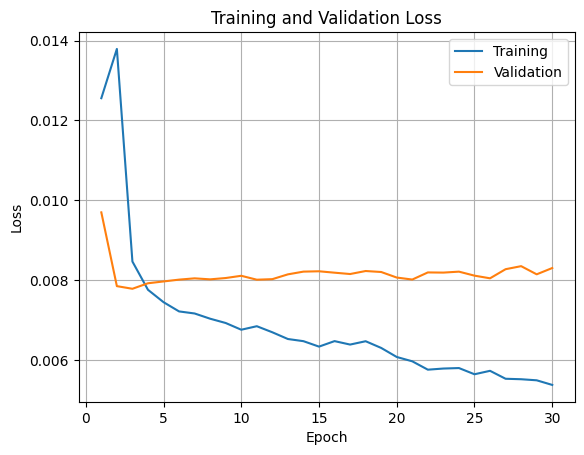

In [132]:
import matplotlib.pyplot as plt

epoch_list = [i for i in range(1, len(train_loss_list)+1)]

plt.plot(epoch_list, train_loss_list, label='Training', linestyle='-')

# 검증 손실 그래프
plt.plot(epoch_list, valid_loss_list, label='Validation', linestyle='-')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

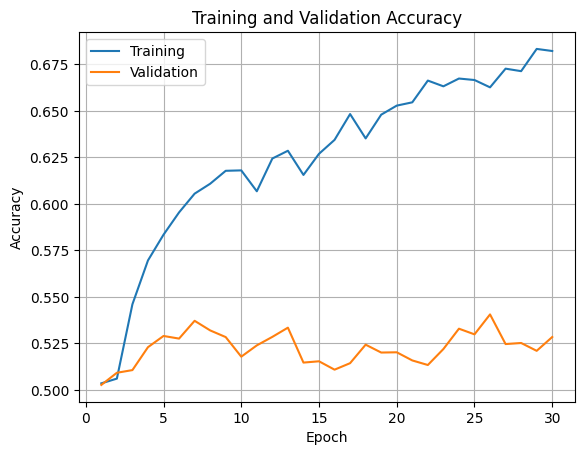

In [133]:
import matplotlib.pyplot as plt

epoch_list = [i for i in range(1, len(train_loss_list)+1)]

plt.plot(epoch_list, train_acc_list, label='Training', linestyle='-')

# 검증 손실 그래프
plt.plot(epoch_list, valid_acc_list, label='Validation', linestyle='-')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# 4. Evaluation

In [42]:
check_point = "ckpt_TS/model_final_01/ckpt-28.pt"

ckpt = torch.load(check_point)
model.load_state_dict(ckpt['model'])

<All keys matched successfully>

In [43]:
model.eval()
progress_bar = tqdm(range(len(test_dataloader)))
test_loss = 0
acc = 0
for batch in test_dataloader:
    past_values = batch['past_values'].to(device)
    future_values = batch['future_values'].to(device)
    
    outputs = model(past_values)
    sum_future_values = torch.sum(future_values, dim=1)
    loss = loss_fn(outputs.squeeze(), sum_future_values)

    pred = outputs.squeeze()
    label = sum_future_values
    acc += sum(pred * label > 0).item()

    progress_bar.update(1)

    test_loss += loss

test_loss /= len(test_dataloader)
acc /= len(test_dataset)
print(f"test loss: {test_loss:.7f}, test accuracy: {acc:.3f}")

  0%|          | 0/35 [00:00<?, ?it/s]

test loss: 0.0098605, test accuracy: 0.555


# 5. Load Model and Prediction

In [213]:
context_length = 120 # 모델이 참조할 데이터 길이 (original: 512)
forecast_horizon = 20 # 모델이 예측할 데이터 길이 (original: 96)
patch_length = 8 # 모델의 patch 길이. context_length의 약수여야 한다. (original: 16)
num_workers = 1 # dataloader worker 개수

In [214]:
from transformers import (
    EarlyStoppingCallback,
    PatchTSMixerConfig,
    PatchTSMixerForPrediction,
    Trainer,
    TrainingArguments,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = PatchTSMixerConfig(
    context_length=context_length,
    prediction_length=forecast_horizon,
    patch_length=patch_length,
    num_input_channels=6, # close, high, low, open, volume, stock_log_return
    patch_stride=patch_length,
    d_model=16,
    num_layers=8,
    expansion_factor=2,
    dropout=0.2,
    head_dropout=0.2,
    mode="common_channel",
    scaling="std",
    prediction_channel_indices=[5] # 'stock_log_return'만을 예측하도록 하자.
)

ts_model = PatchTSMixerForPrediction(config)
ts_model.to(device)

PatchTSMixerForPrediction(
  (model): PatchTSMixerModel(
    (encoder): PatchTSMixerEncoder(
      (patcher): Linear(in_features=15, out_features=16, bias=True)
      (mlp_mixer_encoder): PatchTSMixerBlock(
        (mixers): ModuleList(
          (0-7): 8 x PatchTSMixerLayer(
            (patch_mixer): PatchMixerBlock(
              (norm): PatchTSMixerNormLayer(
                (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
              )
              (mlp): PatchTSMixerMLP(
                (fc1): Linear(in_features=8, out_features=16, bias=True)
                (dropout1): Dropout(p=0.2, inplace=False)
                (fc2): Linear(in_features=16, out_features=8, bias=True)
                (dropout2): Dropout(p=0.2, inplace=False)
              )
              (gating_block): PatchTSMixerGatedAttention(
                (attn_layer): Linear(in_features=8, out_features=8, bias=True)
                (attn_softmax): Softmax(dim=-1)
              )
            )
          

In [215]:
import torch.nn as nn

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

class CustomModel(nn.Module):
    def __init__(self, ts_model=ts_model):
        super().__init__()
        self.ts_model = ts_model

    def forward(self, past_values):
        prediction = self.ts_model(past_values=past_values)
        return prediction

model = CustomModel()

model.to(device)

CustomModel(
  (ts_model): PatchTSMixerForPrediction(
    (model): PatchTSMixerModel(
      (encoder): PatchTSMixerEncoder(
        (patcher): Linear(in_features=15, out_features=16, bias=True)
        (mlp_mixer_encoder): PatchTSMixerBlock(
          (mixers): ModuleList(
            (0-7): 8 x PatchTSMixerLayer(
              (patch_mixer): PatchMixerBlock(
                (norm): PatchTSMixerNormLayer(
                  (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
                )
                (mlp): PatchTSMixerMLP(
                  (fc1): Linear(in_features=8, out_features=16, bias=True)
                  (dropout1): Dropout(p=0.2, inplace=False)
                  (fc2): Linear(in_features=16, out_features=8, bias=True)
                  (dropout2): Dropout(p=0.2, inplace=False)
                )
                (gating_block): PatchTSMixerGatedAttention(
                  (attn_layer): Linear(in_features=8, out_features=8, bias=True)
                  (attn_s

In [216]:
check_point = "ckpt/model_01/ckpt-16.pt"

ckpt = torch.load(check_point)
model.load_state_dict(ckpt['model'])

<All keys matched successfully>

In [220]:
test_sample = test_dataset[-1]
print(test_sample)

{'past_values': tensor([[ 7.0255e-01,  7.2037e-01,  7.1189e-01,  6.1386e-01, -2.9464e-01,
         -1.2320e-02],
        [ 7.0255e-01,  6.8959e-01,  5.8505e-01,  5.2000e-01, -2.2122e-01,
          0.0000e+00],
        [ 8.8961e-01,  9.0505e-01,  9.0215e-01,  7.7028e-01, -8.2232e-02,
          2.4491e-02],
        [ 6.4020e-01,  6.5881e-01,  6.4847e-01,  7.3900e-01,  7.7452e-03,
         -3.2790e-02],
        [ 6.7138e-01,  8.4349e-01,  7.1189e-01,  8.9542e-01, -1.5248e-01,
          4.1580e-03],
        [ 8.5843e-01,  7.8193e-01,  7.4360e-01,  6.7643e-01,  8.1916e-01,
          2.4591e-02],
        [ 8.8961e-01,  8.1271e-01,  9.0215e-01,  8.0157e-01, -2.6344e-01,
          4.0404e-03],
        [ 9.8314e-01,  9.6661e-01,  1.0290e+00,  1.1144e+00, -3.1898e-01,
          1.2024e-02],
        [ 7.0255e-01,  7.8193e-01,  8.3873e-01,  9.2670e-01, -2.2350e-01,
         -3.6515e-02],
        [ 5.4667e-01,  5.6646e-01,  6.4847e-01,  5.8257e-01, -2.6066e-01,
         -2.0878e-02],
        [ 3.59

In [222]:
scaler_list = test_sample['scaler']

past_values = test_sample["past_values"].unsqueeze(0).to(device)
outputs = model(past_values=past_values) # 2차원 텐서가 아닌 3차원 텐서로 입력되어야 함.
outputs.prediction_outputs # 예측

tensor([[[-0.0048],
         [-0.0043],
         [-0.0074],
         [-0.0007],
         [-0.0080],
         [-0.0064],
         [-0.0051],
         [-0.0078],
         [ 0.0003],
         [-0.0045],
         [-0.0106],
         [-0.0057],
         [ 0.0004],
         [-0.0100],
         [ 0.0044],
         [-0.0001],
         [-0.0048],
         [-0.0026],
         [-0.0056],
         [ 0.0032]]], device='cuda:0', grad_fn=<AddBackward0>)

In [223]:
test_sample["future_values"] # 정답

tensor([-0.0054, -0.0065,  0.0161,  0.0064, -0.0542, -0.0214, -0.0383, -0.0024,
         0.0036, -0.0191, -0.0356,  0.0050,  0.0330, -0.0430, -0.0013, -0.0267,
         0.0039, -0.0169,  0.0013,  0.0595])